In [3]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import isodata
import os
from tqdm import tqdm

In [4]:
path_home = os.getcwd()
path_data = path_home + '/data/'

In [5]:
caiso = isodata.CAISO()

In [6]:
def get_rt_efficiency(duration):
    if duration < 12:
        return 0.925
    if duration < 48:
        return 0.86
    return 0.70

In [9]:
# write months of data to temporary location
nodes = caiso.trading_hub_locations
# nodes = nodes[2]
market = 'REAL_TIME_15_MIN'
years = [2020, 2021, 2022]
sleep=5

In [ ]:
for node in nodes:
    path_node = f'{path_data}caiso_{node.lower()}/'
    for y in years:
        for m in tqdm(range(1,12+1)):
            # define start/ end dates
            dt_start = f'{m}/1/{y}'
            if m == 12:
                dt_end = f'{1}/1/{y+1}'
            else:
                dt_end = f'{m+1}/1/{y}'

            # pull data
            caiso_month = caiso.get_historical_lmp(date=dt_start, end=dt_end, 
                                                   market=market, locations=nodes, 
                                                   sleep=sleep, verbose=False)

            # save chunk; If folder doesn't exist, then create it.
            if not os.path.isdir(path_node):
                os.makedirs(path_node)
                print("created folder: ", path_node)
            caiso_month.to_csv(f'{path_node}{market.lower()}_y{y}m{m}.csv', index=False)

In [10]:
# read in data
data = pd.DataFrame([])
for node in tqdm(nodes[0:2]):
    path_node = f'{path_data}caiso_{node.lower()}/'
    for y in years:
        for m in range(1, 12+1):
            d = pd.read_csv(f'{path_node}{market.lower()}_y{y}m{m}.csv')
            data = pd.concat([d, data])

data = data.sort_values(['Location', 'Time']).reset_index()
t, d = data.shape

100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]


In [11]:
pn = data.LMP[data.Location == nodes[0]].to_numpy() # prices are $/MWh 
ps = data.LMP[data.Location == nodes[1]].to_numpy() # prices are $/MWh
# pc = data.LMP[data.Location == nodes[2]].to_numpy() # prices are $/MWh

In [12]:
def get_battery_schedule(px, duration, charge_capacity, use_efficiency=True):
    t = len(px)
    energy_capacity = duration*charge_capacity
    if use_efficiency:
        rt_efficiency = get_rt_efficiency(duration)
    else:
        rt_efficiency = 1
    
    # variables
    c = cp.Variable(t) # charging at time t
    d = cp.Variable(t) # dischargint at time t
    e = cp.Variable(t) # energy at time t
    # constraints
    constraints = [e[1:] == e[:t-1] + c[:t-1]/4 - d[:t-1]/4] # evolution of energy over time, divide by 4 since 15min intervals
    constraints += [e[0] == 0] # must start at 0
    constraints += [e <= energy_capacity, e >= 0] # energy capacity requirements
    constraints += [c <= charge_capacity, c >= 0] # power capacity requirements
    constraints += [d <= charge_capacity, d >= 0] # power capacity requirements
    # problem
    obj = cp.Maximize(px @ (rt_efficiency*d/4 - c/4)) # divide by 4 since 15min intervals
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    return e.value, c.value, d.value, prob.value

In [20]:
def get_optimal_performance(p, duration, capacity, use_efficiency=True):
    e, c, d, rev = get_battery_schedule(p, duration=duration, charge_capacity=capacity, use_efficiency=use_efficiency)
    schedule = c - d
    if use_efficiency:
        revenue = np.cumsum(p*(get_rt_efficiency(duration)*d/4 - c/4))
    else:
        revenue = np.cumsum(p*(d/4 - c/4))

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)
    ax1r = ax[1].twinx()
    ax[0].set_title(f'Duration: {duration}hrs; Capacity: {capacity}MW; Round-trip efficiency: {use_efficiency}\nRevenue: ${rev:,.2f}')
    ax[0].set_ylabel('Energy storage (MWh)\nDis/charge rate (MW)')
    ax[1].set_xlabel(f'hrs from {pd.to_datetime(data.Time[t*y]).date()}')
    ax1r.set_ylabel('Price ($/MWh)')
    ax[1].set_ylabel('Revenue ($)')
    ax[0].step(np.arange(t)/4, schedule, alpha=0.75, color='red', label='charge/discharge schedule')
    ax1r.plot(np.arange(t)/4, p, alpha=0.15, color='grey', label='spot prices')
    ax[0].plot(np.arange(t)/4, e, alpha=0.75, label='storage')
    ax[1].plot(np.arange(t)/4, revenue, alpha=0.75, color='green', label='revenue')
    ax[0].legend()
    ax[1].legend()
    plt.show()

## Revenue over a year, by battery duration (actual efficiencies)

In [30]:
t = 4*24*30*12
durations = [4, 6, 8, 12, 24, 48, 100]
capacity = 200
y=0
p = pn[t*y:t*(y+1)]

100%|█████████████████████████████████████████████| 7/7 [00:16<00:00,  2.32s/it]


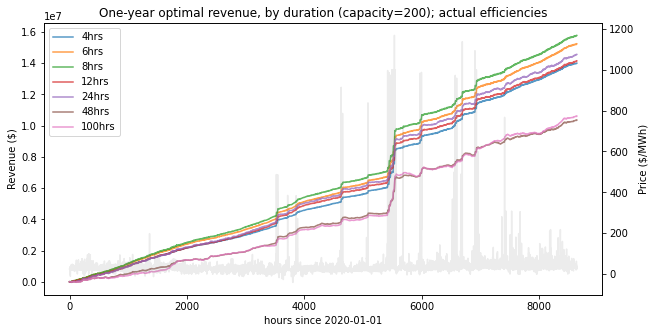

In [31]:
fig, ax0 = plt.subplots(figsize=(10,5))
ax1 = ax0.twinx()
ax1.plot(np.arange(t)/4, p, color='grey', alpha=0.15)
for dur in tqdm(durations):
    e, c, d, rev = get_battery_schedule(p, duration=dur, charge_capacity=capacity, use_efficiency=True)
    revenue = np.cumsum(p*(get_rt_efficiency(dur)*d/4 - c/4))
    ax0.plot(np.arange(t)/4, revenue, alpha=0.75, label=f'{dur}hrs')

ax0.set_title(f'One-year optimal revenue, by duration (capacity={capacity}); actual efficiencies')
ax0.set_ylabel('Revenue ($)')
ax0.set_xlabel(f'hours since {pd.to_datetime(data.Time[t*y]).date()}')
ax1.set_ylabel('Price ($/MWh)')
ax0.legend()
plt.show()

## Revenue over a year, by battery duration (perfect efficiency)

100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.09s/it]


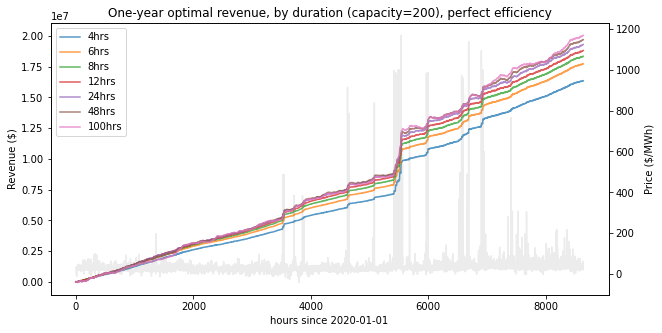

In [32]:
fig, ax0 = plt.subplots(figsize=(10,5))
ax1 = ax0.twinx()
ax1.plot(np.arange(t)/4, p, color='grey', alpha=0.15)
for dur in tqdm(durations):
    e, c, d, rev = get_battery_schedule(p, duration=dur, charge_capacity=capacity, use_efficiency=False)
    revenue = np.cumsum(p*(d/4 - c/4))
    ax0.plot(np.arange(t)/4, revenue, alpha=0.75, label=f'{dur}hrs')

ax0.set_title(f'One-year optimal revenue, by duration (capacity={capacity}), perfect efficiency')
ax0.set_ylabel('Revenue ($)')
ax0.set_xlabel(f'hours since {pd.to_datetime(data.Time[t*y]).date()}')
ax1.set_ylabel('Price ($/MWh)')
ax0.legend()
plt.show()

## Look at optimal performance by zone and duration (6hr vs 100hr)
### One year (actual efficiencies)

In [33]:
t = 4*24*30*12
y=0

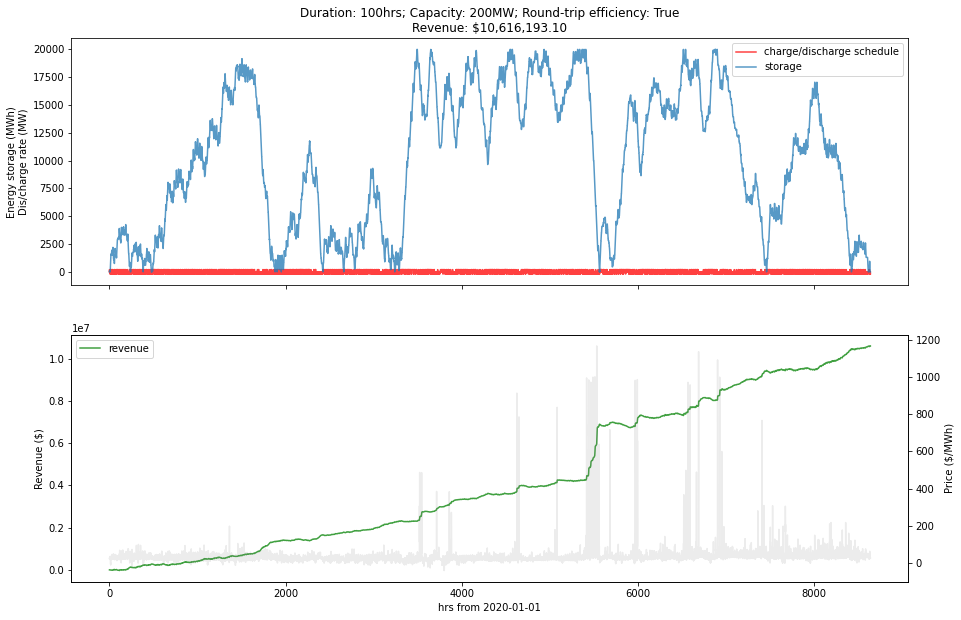

In [34]:
get_optimal_performance(p=pn[t*y:t*(y+1)], duration=100, capacity=200, use_efficiency=True)

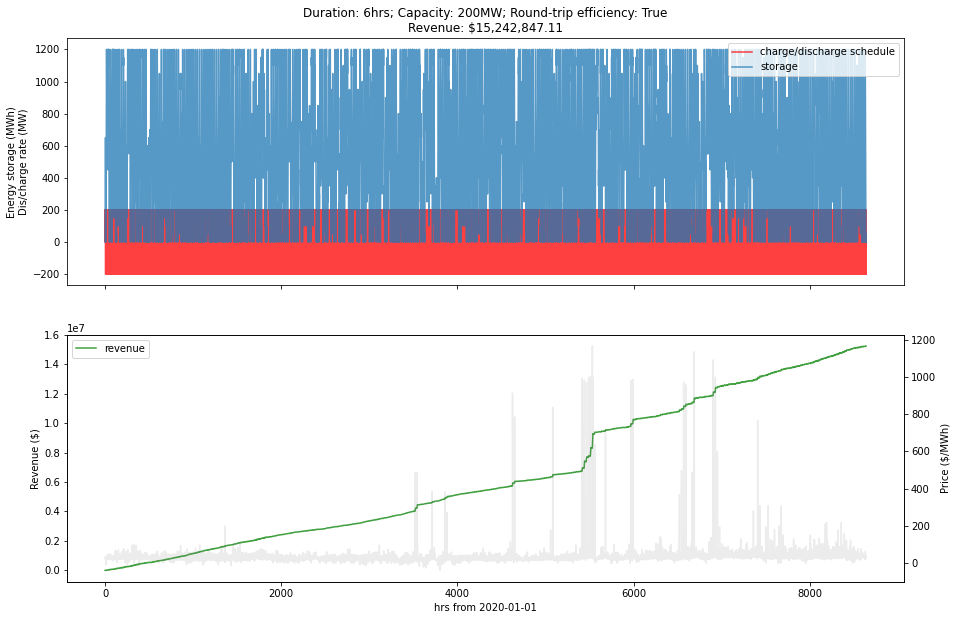

In [35]:
get_optimal_performance(p=pn[t*y:t*(y+1)], duration=6, capacity=200, use_efficiency=True)

### One year (assume perfectly efficient)

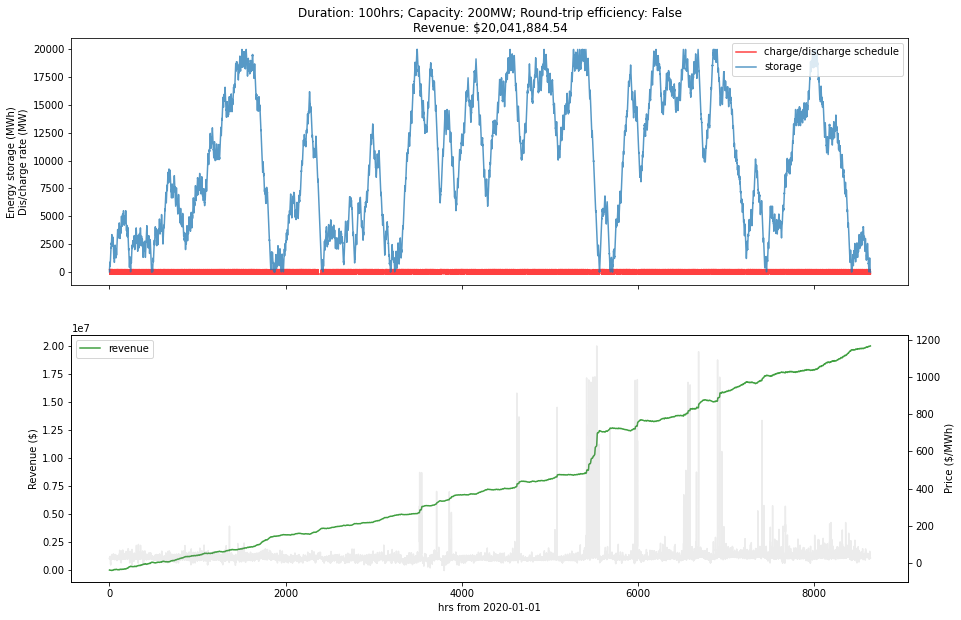

In [36]:
get_optimal_performance(p=pn[t*y:t*(y+1)], duration=100, capacity=200, use_efficiency=False)

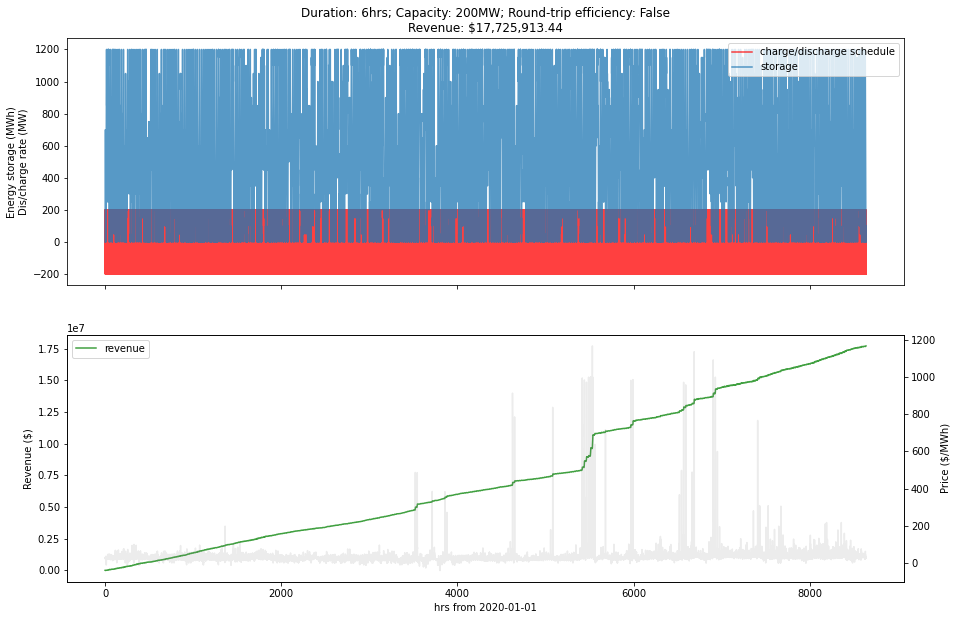

In [37]:
get_optimal_performance(p=pn[t*y:t*(y+1)], duration=6, capacity=200, use_efficiency=False)

## Look at relationship between revenue and duration

### One year (actual efficiencies)

In [125]:
t = 4*24*30*12
p = pn[:t]
cap_step, dur_step = 60, 5
cap_max, dur_max = 300, 100
durations = np.arange(1, dur_max + dur_step, dur_step)
capacities = np.arange(cap_step, cap_max + cap_step, cap_step)
log = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(tqdm(capacities)):
    for j, dur in enumerate(durations):
        __, __, __, log[i, j] = get_battery_schedule(p, duration=dur, charge_capacity=cap, use_efficiency=True)
        

100%|█████████████████████████████████████████████| 5/5 [03:47<00:00, 45.60s/it]


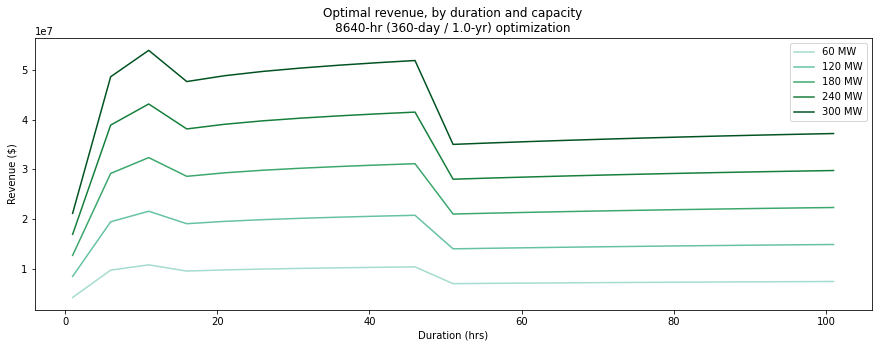

In [126]:
# plot
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(15, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap, color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr / {int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()

### One year (perfect efficiency)

In [127]:
t = 4*24*30*12
p = pn[:t]
cap_step, dur_step = 60, 5
cap_max, dur_max = 300, 100
durations = np.arange(1, dur_max + dur_step, dur_step)
capacities = np.arange(cap_step, cap_max + cap_step, cap_step)
log = np.zeros((len(capacities), len(durations)))
for i, cap in enumerate(tqdm(capacities)):
    for j, dur in enumerate(durations):
        __, __, __, log[i, j] = get_battery_schedule(p, duration=dur, charge_capacity=cap, use_efficiency=False)
        


100%|█████████████████████████████████████████████| 5/5 [03:15<00:00, 39.03s/it]


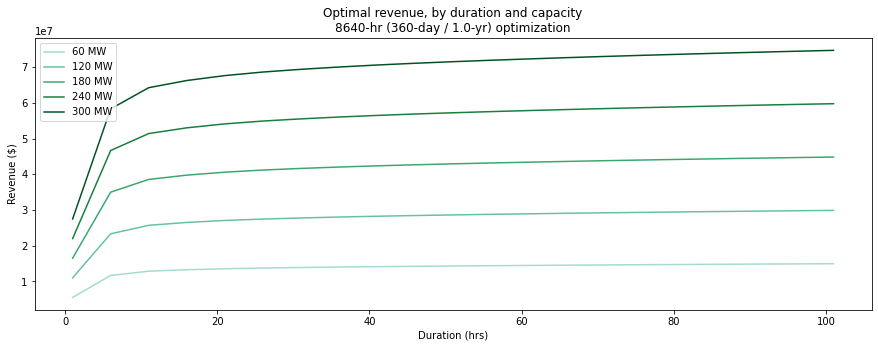

In [128]:
colors = plt.cm.BuGn(np.linspace(0.35,0.95,log.shape[0]))

fig = plt.figure(figsize=(15, 5))
for i, cap in enumerate(log):
    plt.plot(durations, cap, color=colors[i], label=f'{(i+1)*cap_step} MW')
    
plt.title(f'Optimal revenue, by duration and capacity\n{int(t/4)}-hr ({int(t/4/24)}-day / {np.round(t/4/24/365, 1)}-yr) optimization')
plt.xlabel('Duration (hrs)')
plt.ylabel('Revenue ($)')
plt.legend()
plt.show()